In [1]:
import os
import sys
import time
from pathlib import Path

import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from PIL import Image
import seaborn as sb

from col_dtypes import ColDataTypes

In [2]:
data_folder = "../../data/" # root data folder
dpi = 50 # spectrogram image resolution

chunk_id = 2 # chunk 1 is noise, chunks 2-6 are earthquake signals
assert chunk_id > 0 and chunk_id <= 6

In [3]:
col_dtypes = ColDataTypes()
dtypes = col_dtypes.get_initial_dtype_dict()
date_cols = col_dtypes.get_date_cols()

csv_pth = os.path.join(data_folder, f'raw/chunk{chunk_id}/chunk{chunk_id}.csv') # chunk metadata
eqpath = os.path.join(data_folder, f'raw/chunk{chunk_id}/chunk{chunk_id}.hdf5') # chunk earthquake data

chunk = pd.read_csv(csv_pth, dtype=dtypes, parse_dates=date_cols, encoding='utf-8')
print(eqpath)

processed_csv_save_pth = os.path.join(data_folder, f'raw/chunk{chunk_id}/chunk{chunk_id}_processed.csv') # processed metadata save pth

chunk.columns

../../data/raw/chunk2/chunk2.hdf5


Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude', 'source_longitude',
       'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name'],
      dtype='object')

# Data Cleaning

In [4]:
# Get chunk w relevent columns
arrival_df = chunk
# Convert 'coda_end_sample' to int
arrival_df.loc[:, ['coda_end_sample']] = arrival_df['coda_end_sample'].apply(lambda x: int(x[2:-3]))
arrival_df.astype({
    'p_arrival_sample': 'int16',
    's_arrival_sample': 'int16',
    })
# Check if 'p_status' == 's_status'
arrival_df.loc[:, ['same_status?']] = arrival_df[['p_status', 's_status']].apply(lambda x: x['p_status'] == x['s_status'], axis=1)

# New columns

In [5]:
arrival_df.loc[:, ['p_duration']] = arrival_df.apply(lambda col: col['s_arrival_sample'] - col['p_arrival_sample'], axis=1)
arrival_df.loc[:, ['s_duration']] = arrival_df.apply(lambda col: col['coda_end_sample'] - col['s_arrival_sample'], axis=1)

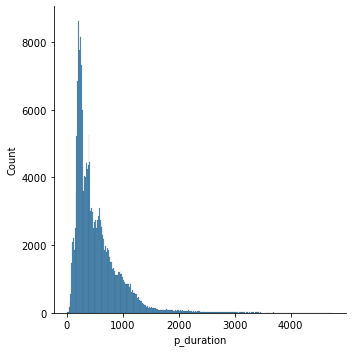

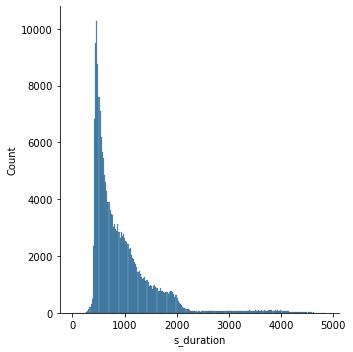

In [6]:
for i in ['p_duration', 's_duration']:
    sb.displot(data = arrival_df, x = i)

plt.show()

In [7]:
# Find min/max p and s wave durations
arrival_df[['p_duration', 's_duration']].describe()

,p_duration,s_duration
count,200000.000000,200000.000000
mean,543.476347,959.112945
std,438.937680,630.377232
min,1.000000,8.000000
25%,246.000000,531.000000
50%,408.000000,758.000000
75%,699.000000,1156.000000
max,4744.000000,4859.000000


In [8]:
def filterDuration(min_acceptable_duration, df):
    acceptable_duration_cond = (df['p_duration'] >= min_acceptable_duration) \
                               & (df['s_duration'] >= min_acceptable_duration)
    new_arrival_df = df.loc[acceptable_duration_cond, :].reset_index(drop=True)
    
    new_arrival_df.loc[:, ['p_duration', 's_duration']]
    
    return new_arrival_df

In [9]:
# only accept waveforms that satisfy 'min_acceptable_duration' 
acceptable_duration = 500 # 100 == 1 second

new_arrival_df = filterDuration(acceptable_duration, arrival_df)

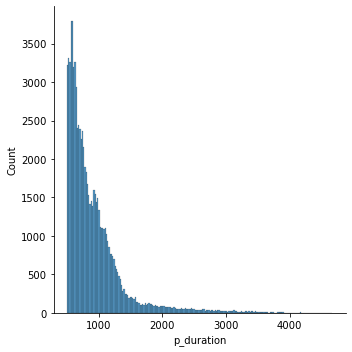

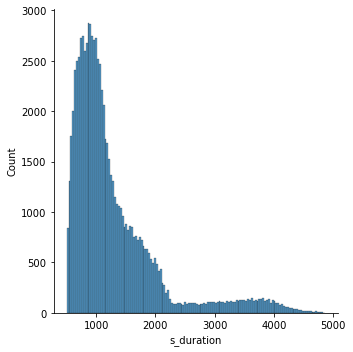

In [10]:
for i in ['p_duration', 's_duration']:
    sb.displot(data = new_arrival_df, x = i)

plt.show()

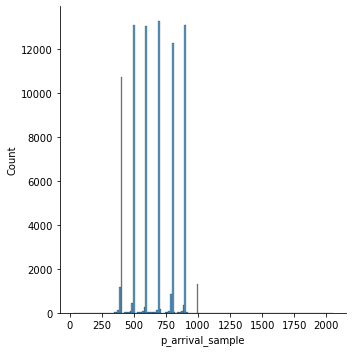

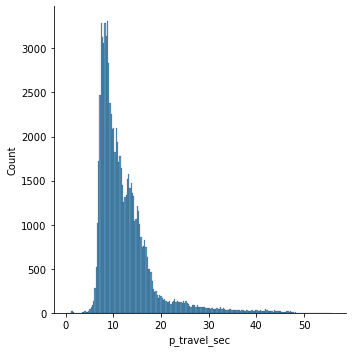

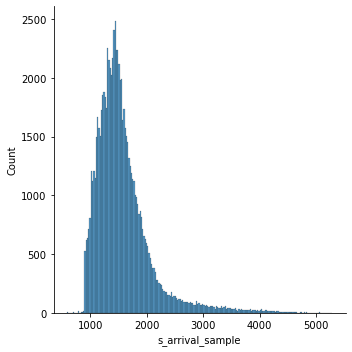

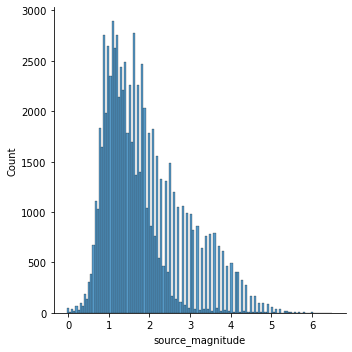

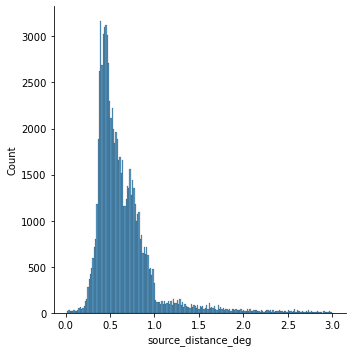

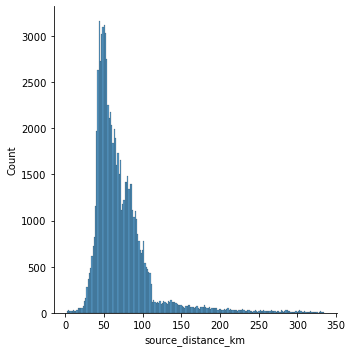

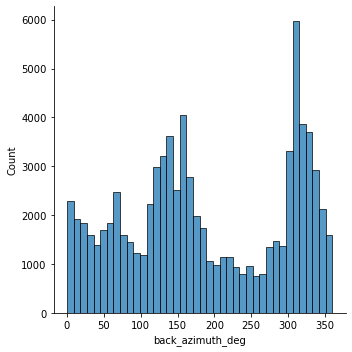

In [14]:
toVisualise = ['p_arrival_sample', 'p_travel_sec', 's_arrival_sample', 'source_magnitude',
               'source_distance_deg', 'source_distance_km', 'back_azimuth_deg']

for i in toVisualise:
    sb.displot(data = new_arrival_df, x = i)

plt.show()

In [11]:
# Save resultant df
new_arrival_df.to_csv(processed_csv_save_pth, index=False)
new_arrival_df.loc[:, ['p_arrival_sample', 's_arrival_sample', 'p_status', 's_status', 'coda_end_sample']]

,p_arrival_sample,s_arrival_sample,p_status,s_status,coda_end_sample
0,700.0,1894.0,manual,manual,2896
1,600.0,1763.0,manual,manual,5508
2,500.0,1678.0,manual,manual,3114
3,900.0,2086.0,manual,manual,3152
4,700.0,1897.0,manual,manual,3134
...,...,...,...,...,...
81745,700.0,1312.0,manual,manual,2272
81746,598.0,1284.0,autopicker,autopicker,2316
81747,500.0,1348.0,manual,manual,2382
81748,692.0,1444.0,autopicker,autopicker,2126


In [12]:
data_folder = "../../data/" # root data folder
save_folder = data_folder + 'images/' # folder to save spectrogram images
p_folder = save_folder + 'P/'
fn = p_folder + "109C.TA_20061129121745_EV.png"
np.array(Image.open(fn)).shape

(100, 150, 3)

In [16]:
x = [10, 100, 200, 300, 400, 500, 600]
y = []

for i in x:
    size = len(filterDuration(i, arrival_df))
    y.append(size)
    print(f'Shape of processed dataframe with acceptable duration of {i/100} sec:', size)

Shape of processed dataframe with acceptable duration of 0.1 sec: 199988
Shape of processed dataframe with acceptable duration of 1.0 sec: 196779
Shape of processed dataframe with acceptable duration of 2.0 sec: 174258
Shape of processed dataframe with acceptable duration of 3.0 sec: 130571
Shape of processed dataframe with acceptable duration of 4.0 sec: 102841
Shape of processed dataframe with acceptable duration of 5.0 sec: 81750
Shape of processed dataframe with acceptable duration of 6.0 sec: 62336


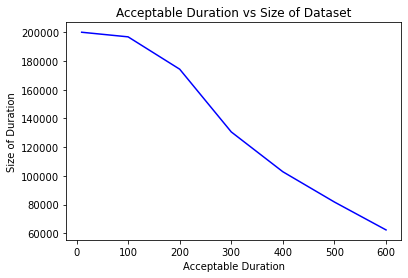

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(x, y, 'b')
plt.title('Acceptable Duration vs Size of Dataset')
plt.xlabel('Acceptable Duration')
plt.ylabel('Size of Duration')
plt.figure()
plt.show()